In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.interpolate import Rbf

In [2]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'#')

start @ Tue Oct  8 06:06:34 2024#


In [3]:
print (katcali.__version__)

2.1.0


In [4]:
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])

10.0 0.8 1.5
14.0 1.5 1.5


In [5]:
fname='1631552188'#'1631667564'#'1631982988'##''##'1630519596'#'1631667564' #'1631552188'#

data=kio.load_data(fname)
print (data)

Name: 1631552188_sdp_l0 (version 4.0)
-------------------------------------------------------------------------------
URL: file:///idia/projects/hi_im/SCI-20210212-MS-01/1631552188/1631552188/1631552188_sdp_l0.full.rdb
Observer: Sean Passmoor  Experiment ID: 20210913-0019
Description: 'HI Intensity observation RISING  epoch 4'
Observed from 2021-09-13 18:56:48.034 SAST to 2021-09-13 21:00:08.903 SAST
Dump rate / period: 0.50021 Hz / 1.999 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m000,m001,m002,m003,m004,m005,m006,m007,m009,m010,m011,m012,m013,m014,m015,m016,m017,m018,m019,m020,m021,m022,m023,m024,m025,m026,m030,m031,m032,m033,m034,m035,m036,m037,m038,m039,m040,m041,m042,m043,m044,m045,m046,m047,m048,m049,m050,m051,m053,m054,m055,m056,m057,m058,m059,m061,m062,m063  116      232
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    c856M4k    1284.000         856.000           4096       208.9

In [6]:
data.obs_script_log

['2021-09-13 16:56:15.650Z INFO     ==========================',
 '2021-09-13 16:56:15.650Z INFO     New data capturing session',
 '2021-09-13 16:56:15.651Z INFO     --------------------------',
 "2021-09-13 16:56:15.651Z INFO     Session CBF = 'cbf' (1 fengine, 2 beamformers, 1 correlator)",
 '2021-09-13 16:56:15.651Z INFO     CBF instruments and streams:',
 "2021-09-13 16:56:15.651Z INFO       -> 'wide' (1 fengine, 2 beamformers, 1 correlator)",
 "2021-09-13 16:56:15.652Z INFO            -> fengine    'wide.antenna-channelised-voltage' (128 inputs)",
 "2021-09-13 16:56:15.652Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0y' (64 inputs)",
 "2021-09-13 16:56:15.653Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0x' (64 inputs)",
 "2021-09-13 16:56:15.653Z INFO            -> correlator 'wide.baseline-correlation-products' (128 inputs)",
 "2021-09-13 16:56:15.653Z INFO     Session SDP = 'sdp' (1 product)",
 '2021-09-13 16:56:15.653Z INFO     SD

In [7]:
ant='m000'
pol='v'
recv=ant+pol


In [8]:
data.select(ants=ant,pol=pol,scans='track')
dp_t=data.dumps
print (np.shape(dp_t))
data.select()

data.select(ants=ant,pol=pol)
print (np.shape(data.vis))
ra,dec,az,el=kio.load_coordinates(data)
timestamps,freqs=kio.load_tf(data)


(490,)
(3702, 4096, 1)


In [9]:
data1=pickle.load(open('/idia/projects/hi_im/raw_vis/SCI-20210212-MS-01/'+str(fname)+'/'+str(fname)+'_'+str(recv)+'_vis_data','rb'), encoding='latin-1')
vis=data1['vis']
flags=data1['flags']
vis_backup=vis.copy()
print (np.shape(vis))
#vis=vis[dp_t,:]
#print np.shape(vis)

(3702, 4096)


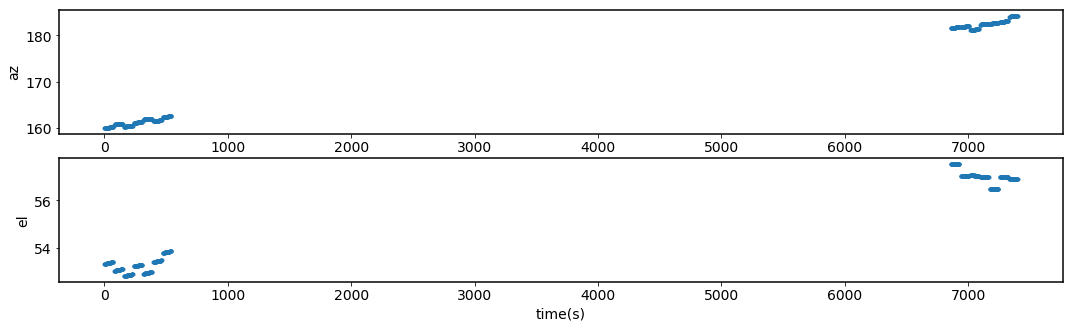

In [10]:
plt.figure(figsize=(18,5))
plt.subplot(211)
plt.plot(timestamps[dp_t]-timestamps[0], az[dp_t], '.')
#plt.xlabel('time(s)')
plt.ylabel('az')
plt.subplot(212)
plt.plot(timestamps[dp_t]-timestamps[0], el[dp_t], '.')
plt.xlabel('time(s)')
plt.ylabel('el')
plt.show()

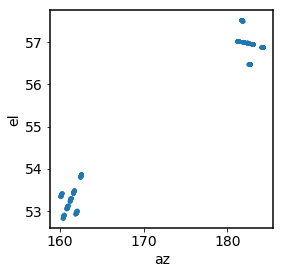

In [11]:
plt.figure(figsize=(4,4))
plt.plot(az[dp_t],el[dp_t],'.')
plt.xlabel('az')
plt.ylabel('el')
plt.show()

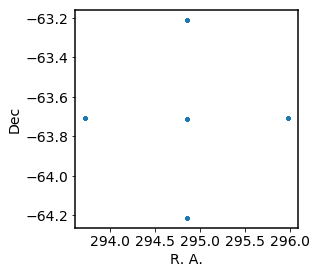

In [12]:
plt.figure(figsize=(4,4))
plt.plot(ra[dp_t],dec[dp_t],'.')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.show()

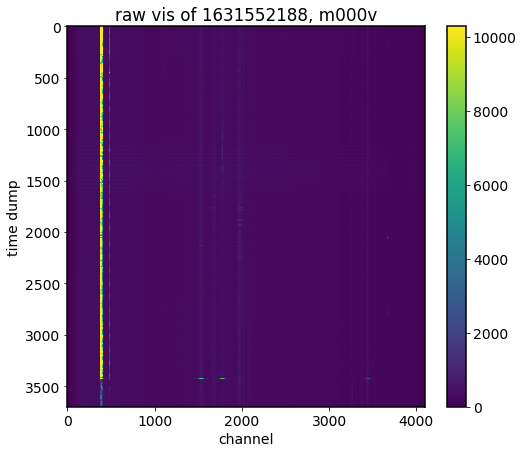

In [13]:
#raw visibility
plt.figure(figsize=(8,7))
plt.imshow(vis,aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
#plt.savefig(str(fname)+'_'+str(recv)+'_raw_vis.pdf')
plt.show()

[ True  True  True ...  True  True  True]
True
[1. 1. 1. ... 1. 1. 1.]


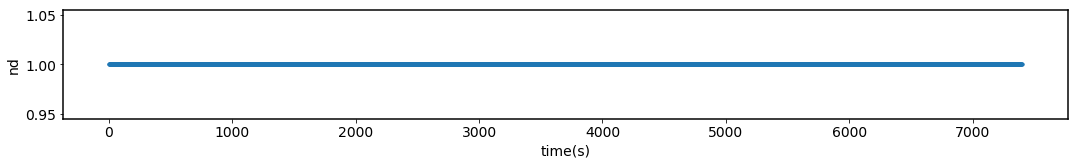

In [14]:
noise_type='coupler'
print (data.sensor['Antennas/{0}/nd_{1}'.format(ant,noise_type)])
print ((data.sensor['Antennas/{0}/nd_{1}'.format(ant,noise_type)]==True).all())

nd_ratio=data.sensor['Antennas/{0}/nd_{1}'.format(ant,noise_type)].astype(float)
print (nd_ratio)

plt.figure(figsize=(18,2))
plt.plot(timestamps-timestamps[0], nd_ratio, '.')
plt.xlabel('time(s)')
plt.ylabel('nd')
plt.show()

In [15]:
##check save_data

In [16]:
data.obs_script_log

['2021-09-13 16:56:15.650Z INFO     ==========================',
 '2021-09-13 16:56:15.650Z INFO     New data capturing session',
 '2021-09-13 16:56:15.651Z INFO     --------------------------',
 "2021-09-13 16:56:15.651Z INFO     Session CBF = 'cbf' (1 fengine, 2 beamformers, 1 correlator)",
 '2021-09-13 16:56:15.651Z INFO     CBF instruments and streams:',
 "2021-09-13 16:56:15.651Z INFO       -> 'wide' (1 fengine, 2 beamformers, 1 correlator)",
 "2021-09-13 16:56:15.652Z INFO            -> fengine    'wide.antenna-channelised-voltage' (128 inputs)",
 "2021-09-13 16:56:15.652Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0y' (64 inputs)",
 "2021-09-13 16:56:15.653Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0x' (64 inputs)",
 "2021-09-13 16:56:15.653Z INFO            -> correlator 'wide.baseline-correlation-products' (128 inputs)",
 "2021-09-13 16:56:15.653Z INFO     Session SDP = 'sdp' (1 product)",
 '2021-09-13 16:56:15.653Z INFO     SD

In [17]:
print ('#check data shape')
print ('-------------------------------------------------')
print ('#select all ants')
data.select()
print ('block related parameters:')
print (np.shape(data.timestamps),np.shape(data.temperature),np.shape(data.humidity),np.shape(data.pressure))
print ('ant related parameters:')
print (np.shape(data.ra),np.shape(data.dec),np.shape(data.az),np.shape(data.el),np.shape(data.parangle))
print ('-------------------------------------------------')
print ('#select one ant')
data.select(ants=ant)
print ('block related parameters:')
print (np.shape(data.timestamps),np.shape(data.temperature),np.shape(data.humidity),np.shape(data.pressure))
print ('ant related parameters:')
print (np.shape(data.ra),np.shape(data.dec),np.shape(data.az),np.shape(data.el),np.shape(data.parangle))
print ('-------------------------------------------------')

#check data shape
-------------------------------------------------
#select all ants
block related parameters:
(3702,) (3702,) (3702,) (3702,)
ant related parameters:
(3702, 58) (3702, 58) (3702, 58) (3702, 58) (3702, 58)
-------------------------------------------------
#select one ant
block related parameters:
(3702,) (3702,) (3702,) (3702,)
ant related parameters:
(3702, 1) (3702, 1) (3702, 1) (3702, 1) (3702, 1)
-------------------------------------------------


In [18]:
'''
data.select()
print len(data.timestamps)
data.select(ants=ant,pol=pol)
print len(data.timestamps)
data.select(ants=ant,pol=pol,scans='track')
print len(data.timestamps)
dp_t=data.dumps
print len(dp_t)
'''

"\ndata.select()\nprint len(data.timestamps)\ndata.select(ants=ant,pol=pol)\nprint len(data.timestamps)\ndata.select(ants=ant,pol=pol,scans='track')\nprint len(data.timestamps)\ndp_t=data.dumps\nprint len(dp_t)\n"

In [19]:
'''
data.select()
print len(data.timestamps)
data.select(ants=ant,pol=pol)
print len(data.timestamps)
ss=data.sensor['Antennas/{0}/activity'.format(ant)]
dp_t2= np.where(ss=='track')[0]
print len(dp_t2)
'''

"\ndata.select()\nprint len(data.timestamps)\ndata.select(ants=ant,pol=pol)\nprint len(data.timestamps)\nss=data.sensor['Antennas/{0}/activity'.format(ant)]\ndp_t2= np.where(ss=='track')[0]\nprint len(dp_t2)\n"

In [20]:
'''
dp_inter=list(set(dp_t).intersection(set(dp_t2)))
print len(dp_inter)
'''

'\ndp_inter=list(set(dp_t).intersection(set(dp_t2)))\nprint len(dp_inter)\n'

In [21]:
'''
dp_diff1=list(set(dp_t)-set(dp_inter))
print len(dp_diff1)
dp_diff2=list(set(dp_t2)-set(dp_inter))
print len(dp_diff2)
'''

'\ndp_diff1=list(set(dp_t)-set(dp_inter))\nprint len(dp_diff1)\ndp_diff2=list(set(dp_t2)-set(dp_inter))\nprint len(dp_diff2)\n'

In [22]:
'''
ch_plot=800
plt.figure(figsize=(12,4))
plt.plot(timestamps[dp_t]-timestamps[0],vis[dp_t,ch_plot],'k.')
plt.plot(timestamps[dp_t2]-timestamps[0],vis[dp_t2,ch_plot],'g.')
plt.plot(timestamps[dp_diff1]-timestamps[0],vis[dp_diff1,ch_plot],'r.')
plt.plot(timestamps[dp_diff2]-timestamps[0],vis[dp_diff2,ch_plot],'m.')
plt.show()
'''

"\nch_plot=800\nplt.figure(figsize=(12,4))\nplt.plot(timestamps[dp_t]-timestamps[0],vis[dp_t,ch_plot],'k.')\nplt.plot(timestamps[dp_t2]-timestamps[0],vis[dp_t2,ch_plot],'g.')\nplt.plot(timestamps[dp_diff1]-timestamps[0],vis[dp_diff1,ch_plot],'r.')\nplt.plot(timestamps[dp_diff2]-timestamps[0],vis[dp_diff2,ch_plot],'m.')\nplt.show()\n"

In [23]:
#start
data2={}

#each block
data.select()
data2['timestamps']=data.timestamps
data2['freqs']=data.freqs
data2['temperature']=data.temperature
data2['humidity']=data.humidity
data2['pressure']=data.pressure
data2['receivers']=data.receivers
data2['obs_script_log']=data.obs_script_log   
data2['header']=data.__str__()
data2['ant_list']=kio.ant_list(data)
#each dish
data.select()
for ant in kio.ant_list(data):
    print (ant,end=' ')
    data.select(ants=ant)
    assert(np.shape(data.ra)[1]==1)
    data2[ant]={
    'ra': data.ra[:,0],    
    'dec':data.dec[:,0],    
    'az':data.az[:,0],
    'el':data.el[:,0],
    'ScanState':data.sensor['Antennas/{0}/activity'.format(ant)], #track
    'nd_ratio':data.sensor['Antennas/{0}/nd_{1}'.format(ant,noise_type)].astype(float),
    'observer_elevation':data.ants[0].observer.elevation,
    'observer_lon_rad':float(data.ants[0].observer.lon),
    'observer_lat_rad':float(data.ants[0].observer.lat)  
    }
d2=kio.RecDictWrapper(data2)

m000 m001 m002 m003 m004 m005 m006 m007 m009 m010 m011 m012 m013 m014 m015 m016 m017 m018 m019 m020 m021 m022 m023 m024 m025 m026 m030 m031 m032 m033 m034 m035 m036 m037 m038 m039 m040 m041 m042 m043 m044 m045 m046 m047 m048 m049 m050 m051 m053 m054 m055 m056 m057 m058 m059 m061 m062 m063 

In [24]:
#check which ant you used
assert((d2.m000.ra==ra).all())
print ((d2.m000.ra==ra).all())

True


In [25]:
fs=open(fname+'_para','wb')
pickle.dump(d2,fs,protocol=2)
fs.close()

In [26]:
print('# _para saved for obs'+ fname)

# _para saved for obs1631552188


In [27]:
d3 = pickle.load(open(fname+'_para','rb'))
print (d3.keys)

['timestamps', 'freqs', 'temperature', 'humidity', 'pressure', 'receivers', 'obs_script_log', 'header', 'ant_list', 'm000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm009', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm018', 'm019', 'm020', 'm021', 'm022', 'm023', 'm024', 'm025', 'm026', 'm030', 'm031', 'm032', 'm033', 'm034', 'm035', 'm036', 'm037', 'm038', 'm039', 'm040', 'm041', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm053', 'm054', 'm055', 'm056', 'm057', 'm058', 'm059', 'm061', 'm062', 'm063']


In [28]:
#check which ant you used
assert((d3.m000.ra==ra).all())
print ((d3.m000.ra==ra).all())

True


In [29]:
print (d3.header)

Name: 1631552188_sdp_l0 (version 4.0)
-------------------------------------------------------------------------------
URL: file:///idia/projects/hi_im/SCI-20210212-MS-01/1631552188/1631552188/1631552188_sdp_l0.full.rdb
Observer: Sean Passmoor  Experiment ID: 20210913-0019
Description: 'HI Intensity observation RISING  epoch 4'
Observed from 2021-09-13 18:56:48.034 SAST to 2021-09-13 21:00:08.903 SAST
Dump rate / period: 0.50021 Hz / 1.999 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m000,m001,m002,m003,m004,m005,m006,m007,m009,m010,m011,m012,m013,m014,m015,m016,m017,m018,m019,m020,m021,m022,m023,m024,m025,m026,m030,m031,m032,m033,m034,m035,m036,m037,m038,m039,m040,m041,m042,m043,m044,m045,m046,m047,m048,m049,m050,m051,m053,m054,m055,m056,m057,m058,m059,m061,m062,m063  116      232
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    c856M4k    1284.000         856.000           4096       208.9

In [30]:
d3.obs_script_log

['2021-09-13 16:56:15.650Z INFO     ==========================',
 '2021-09-13 16:56:15.650Z INFO     New data capturing session',
 '2021-09-13 16:56:15.651Z INFO     --------------------------',
 "2021-09-13 16:56:15.651Z INFO     Session CBF = 'cbf' (1 fengine, 2 beamformers, 1 correlator)",
 '2021-09-13 16:56:15.651Z INFO     CBF instruments and streams:',
 "2021-09-13 16:56:15.651Z INFO       -> 'wide' (1 fengine, 2 beamformers, 1 correlator)",
 "2021-09-13 16:56:15.652Z INFO            -> fengine    'wide.antenna-channelised-voltage' (128 inputs)",
 "2021-09-13 16:56:15.652Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0y' (64 inputs)",
 "2021-09-13 16:56:15.653Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0x' (64 inputs)",
 "2021-09-13 16:56:15.653Z INFO            -> correlator 'wide.baseline-correlation-products' (128 inputs)",
 "2021-09-13 16:56:15.653Z INFO     Session SDP = 'sdp' (1 product)",
 '2021-09-13 16:56:15.653Z INFO     SD

In [31]:
data.select()
for ant in d3.ant_list:
    data.select(ants=ant)
    
    assert(data.ants[0].observer.elevation==d3.__getattribute__(ant).observer_elevation)
    assert(data.ants[0].observer.lon==d3.__getattribute__(ant).observer_lon_rad)
    assert(data.ants[0].observer.lat==d3.__getattribute__(ant).observer_lat_rad)
    print (ant,end=' ')
print ('checked #')

m000 m001 m002 m003 m004 m005 m006 m007 m009 m010 m011 m012 m013 m014 m015 m016 m017 m018 m019 m020 m021 m022 m023 m024 m025 m026 m030 m031 m032 m033 m034 m035 m036 m037 m038 m039 m040 m041 m042 m043 m044 m045 m046 m047 m048 m049 m050 m051 m053 m054 m055 m056 m057 m058 m059 m061 m062 m063 checked #


In [32]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')

end @ Tue Oct  8 06:07:06 2024#
